# Data Understanding

In [116]:
library("dplyr")
library("ggplot2")
library("corrplot")
library("repr")
library("treemapify")

In [62]:
data <- read.csv("../data/train.csv")

In [63]:
head(data)

,loan_id,loan_date,amount,payments,status,frequency,trans_count,credit_count,credit_ratio,withdrawal_count,⋯,urban_ratio,average_salary,entrepreneur_rate,unemployment_rate_avg,crimes_rate_per_thousand,unemployment_growing,crimes_growing,can_afford_loan,can_pay_until,acc_age_when_loan
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,⋯,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,5314,1993-07-05,96396,8033,-1,2,4,4,1.0000000,0,⋯,81.8,9650,100,5.215,0.0550035860,1,0,1,2.502179,105
2,5316,1993-07-11,165960,4610,1,1,37,17,0.4594595,20,⋯,73.5,8369,117,2.945,0.0261292355,1,0,1,11.325141,148
3,6863,1993-07-28,127080,2118,1,1,24,15,0.6250000,9,⋯,53.5,8390,132,3.725,0.0478072821,1,1,1,9.571671,170
4,5325,1993-08-03,105804,2939,1,1,25,13,0.5200000,12,⋯,58.0,8754,137,5.985,0.0554834523,1,1,1,11.668152,185
5,7240,1993-09-06,274740,4579,1,2,27,13,0.4814815,14,⋯,100.0,12541,167,0.505,0.0004191035,1,1,1,8.985128,204
6,6687,1993-09-13,87840,3660,1,1,17,14,0.8235294,3,⋯,41.3,8598,123,4.400,0.0816008605,1,1,1,11.980273,124


We can start by doing some simple plots in order to better understand the data that we will be dealing with.

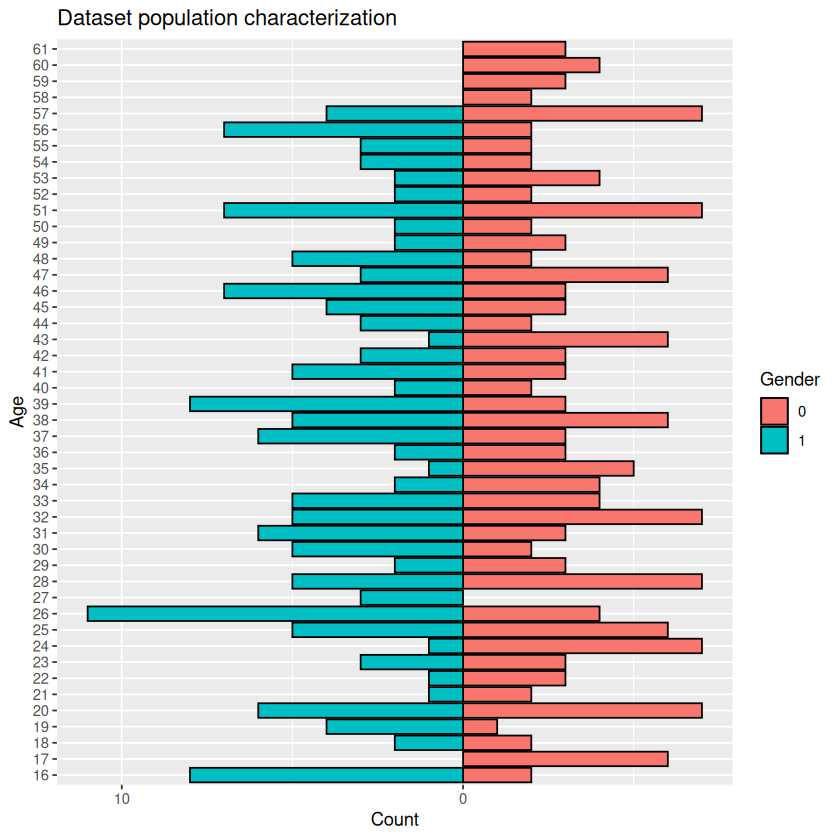

In [64]:
ggplot(data=data,aes(x=as.factor(client_age),fill=as.factor(gender))) + 
  geom_bar(data=subset(data,gender=="0"), color="black") + 
  geom_bar(data=subset(data,gender=="1"),color="black",aes(y=after_stat(count)*(-1))) + 
  scale_y_continuous(breaks=seq(-40,40,10),labels=abs(seq(-40,40,10))) + 
  labs(fill="Gender", x="Age", y="Count", title="Dataset population characterization") +
  coord_flip()

We can see that this dataset is composed of clients between the ages of 16 and 61, having about the same number of male and female.

Since the target variable is the "status", we will try to find how other variables can influence it's result.

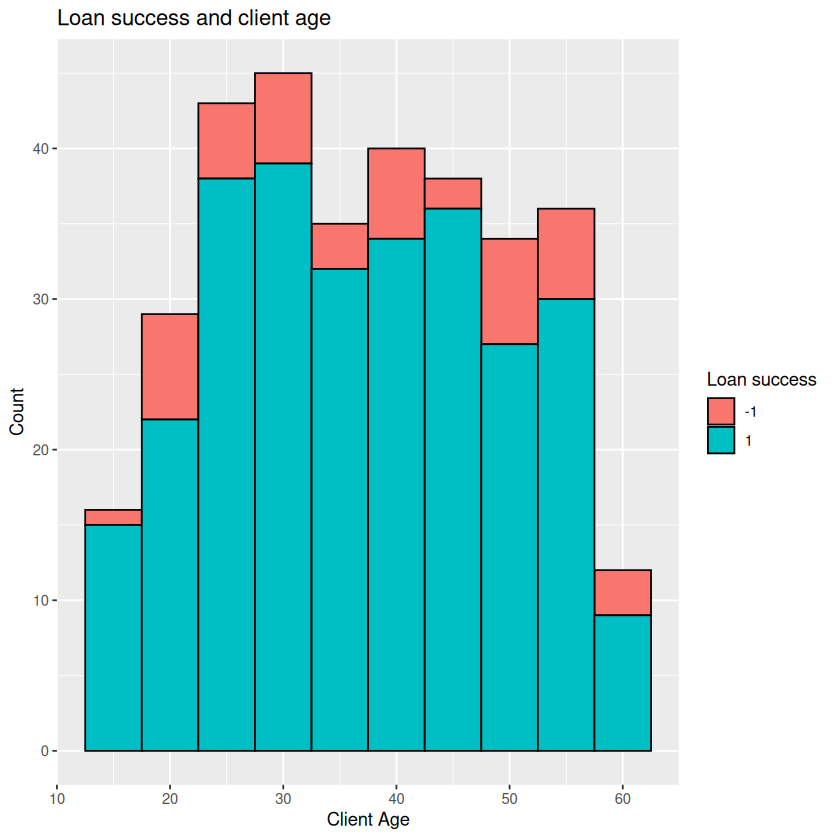

In [140]:
ggplot(data, aes(x=client_age, fill = as.factor(status))) + 
  labs(fill="Loan success", x="Client Age", y="Count", title="Loan success and client age") +
  geom_histogram(binwidth=5, color="black")

From this one, we can't draw any conclusion about age influencing the sucess of a loan.

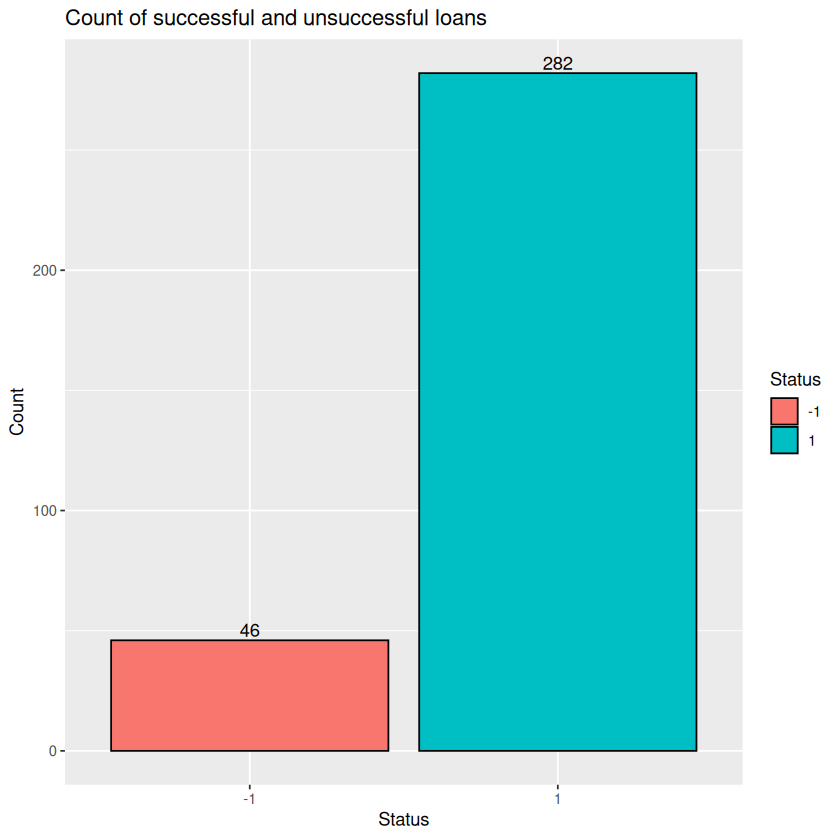

In [66]:
loan_frq <- data %>%
  count(status)

ggplot(loan_frq, aes(x=as.factor(status), y=n, fill=as.factor(status))) + 
  labs(fill="Status", x="Status", y="Count", title="Count of successful and unsuccessful loans") +
  geom_bar(stat = "identity", color="black") +
  geom_text(aes(label=n), position=position_dodge(width=0.9), vjust=-0.25)

This simple graph shows the number of successful (1) and unsuccessful (0) loans. We can now see that there is a very small number of unssuccessful loans when compared to successful. That is something we need to keep in mind for the next steps, as it makes the dataset unbalanced. Possible solutions are to replicate the unsuccessfull loans, reduce successfull loans or create unsuccessfull loans (SMOTE).

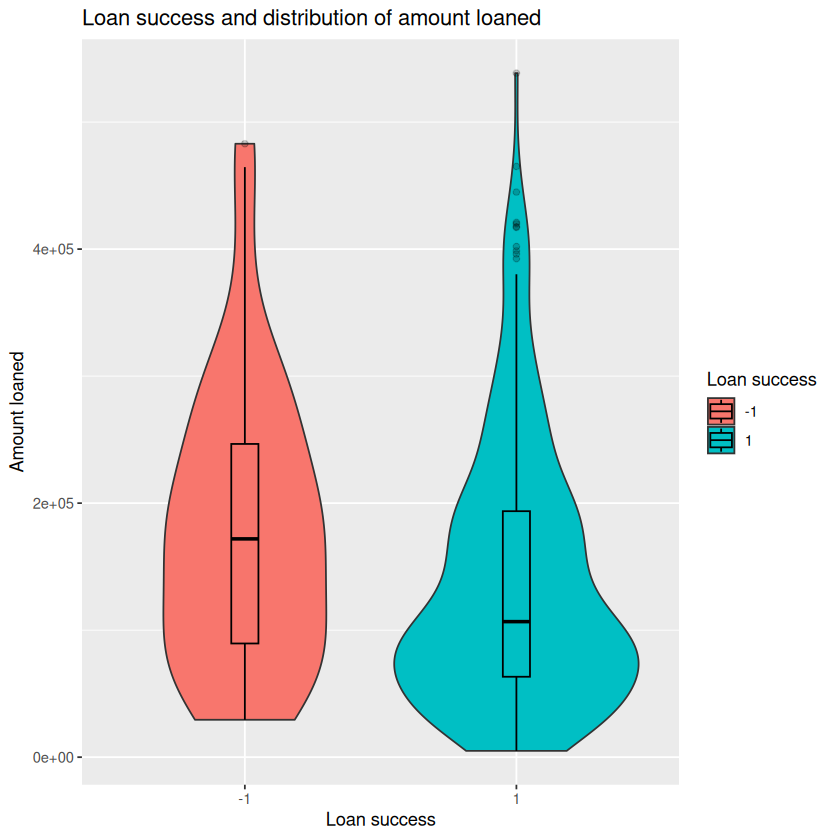

In [141]:
ggplot(data, aes(x=as.factor(status), y=amount, fill=as.factor(status))) + 
  geom_violin() +
  geom_boxplot(width=0.1, color="black", alpha=0.2) +
  labs(fill="Loan success", x="Loan success", y="Amount loaned", title="Loan success and distribution of amount loaned")

Looking at the distribution of the amount loaned for successful and failed loans, we notice that, despite a couple of outliers (shown by the dots above the boxplot line), successful loans involve a smaller amount of money. We won't be removing those outliers as we are not looking for consistency, but rather for finding unusual behaviours that could be associated with failed loans.

`geom_smooth()` using formula = 'y ~ x'


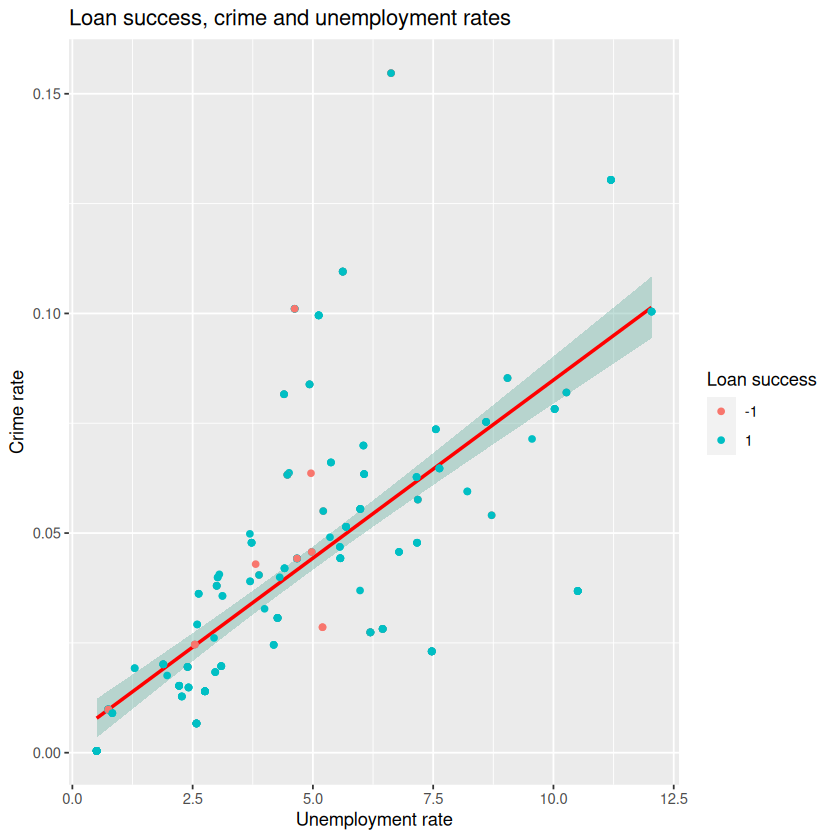

In [144]:
ggplot(data, aes(x=unemployment_rate_avg, y=crimes_rate_per_thousand, color=as.factor(status))) + 
    geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
    labs(color="Loan success", x="Unemployment rate", y="Crime rate", title="Loan success, crime and unemployment rates") + 
    geom_point()

With this graph, we tried to see how the crime rate and the unemployment rate could be associated with the loan success. 
It was not very conclusive in terms of finding correlation with the loan success, showing only that crime rate and unemployment rate are correlated, and that most of the unsuccessful loans were asked in districts with unemployment rate around 5%, which doesn't tell us much.

## Correlation matrix

Now we can try and find correlations between the loan status and other attributes. Let's start by plotting the correlation matrix.

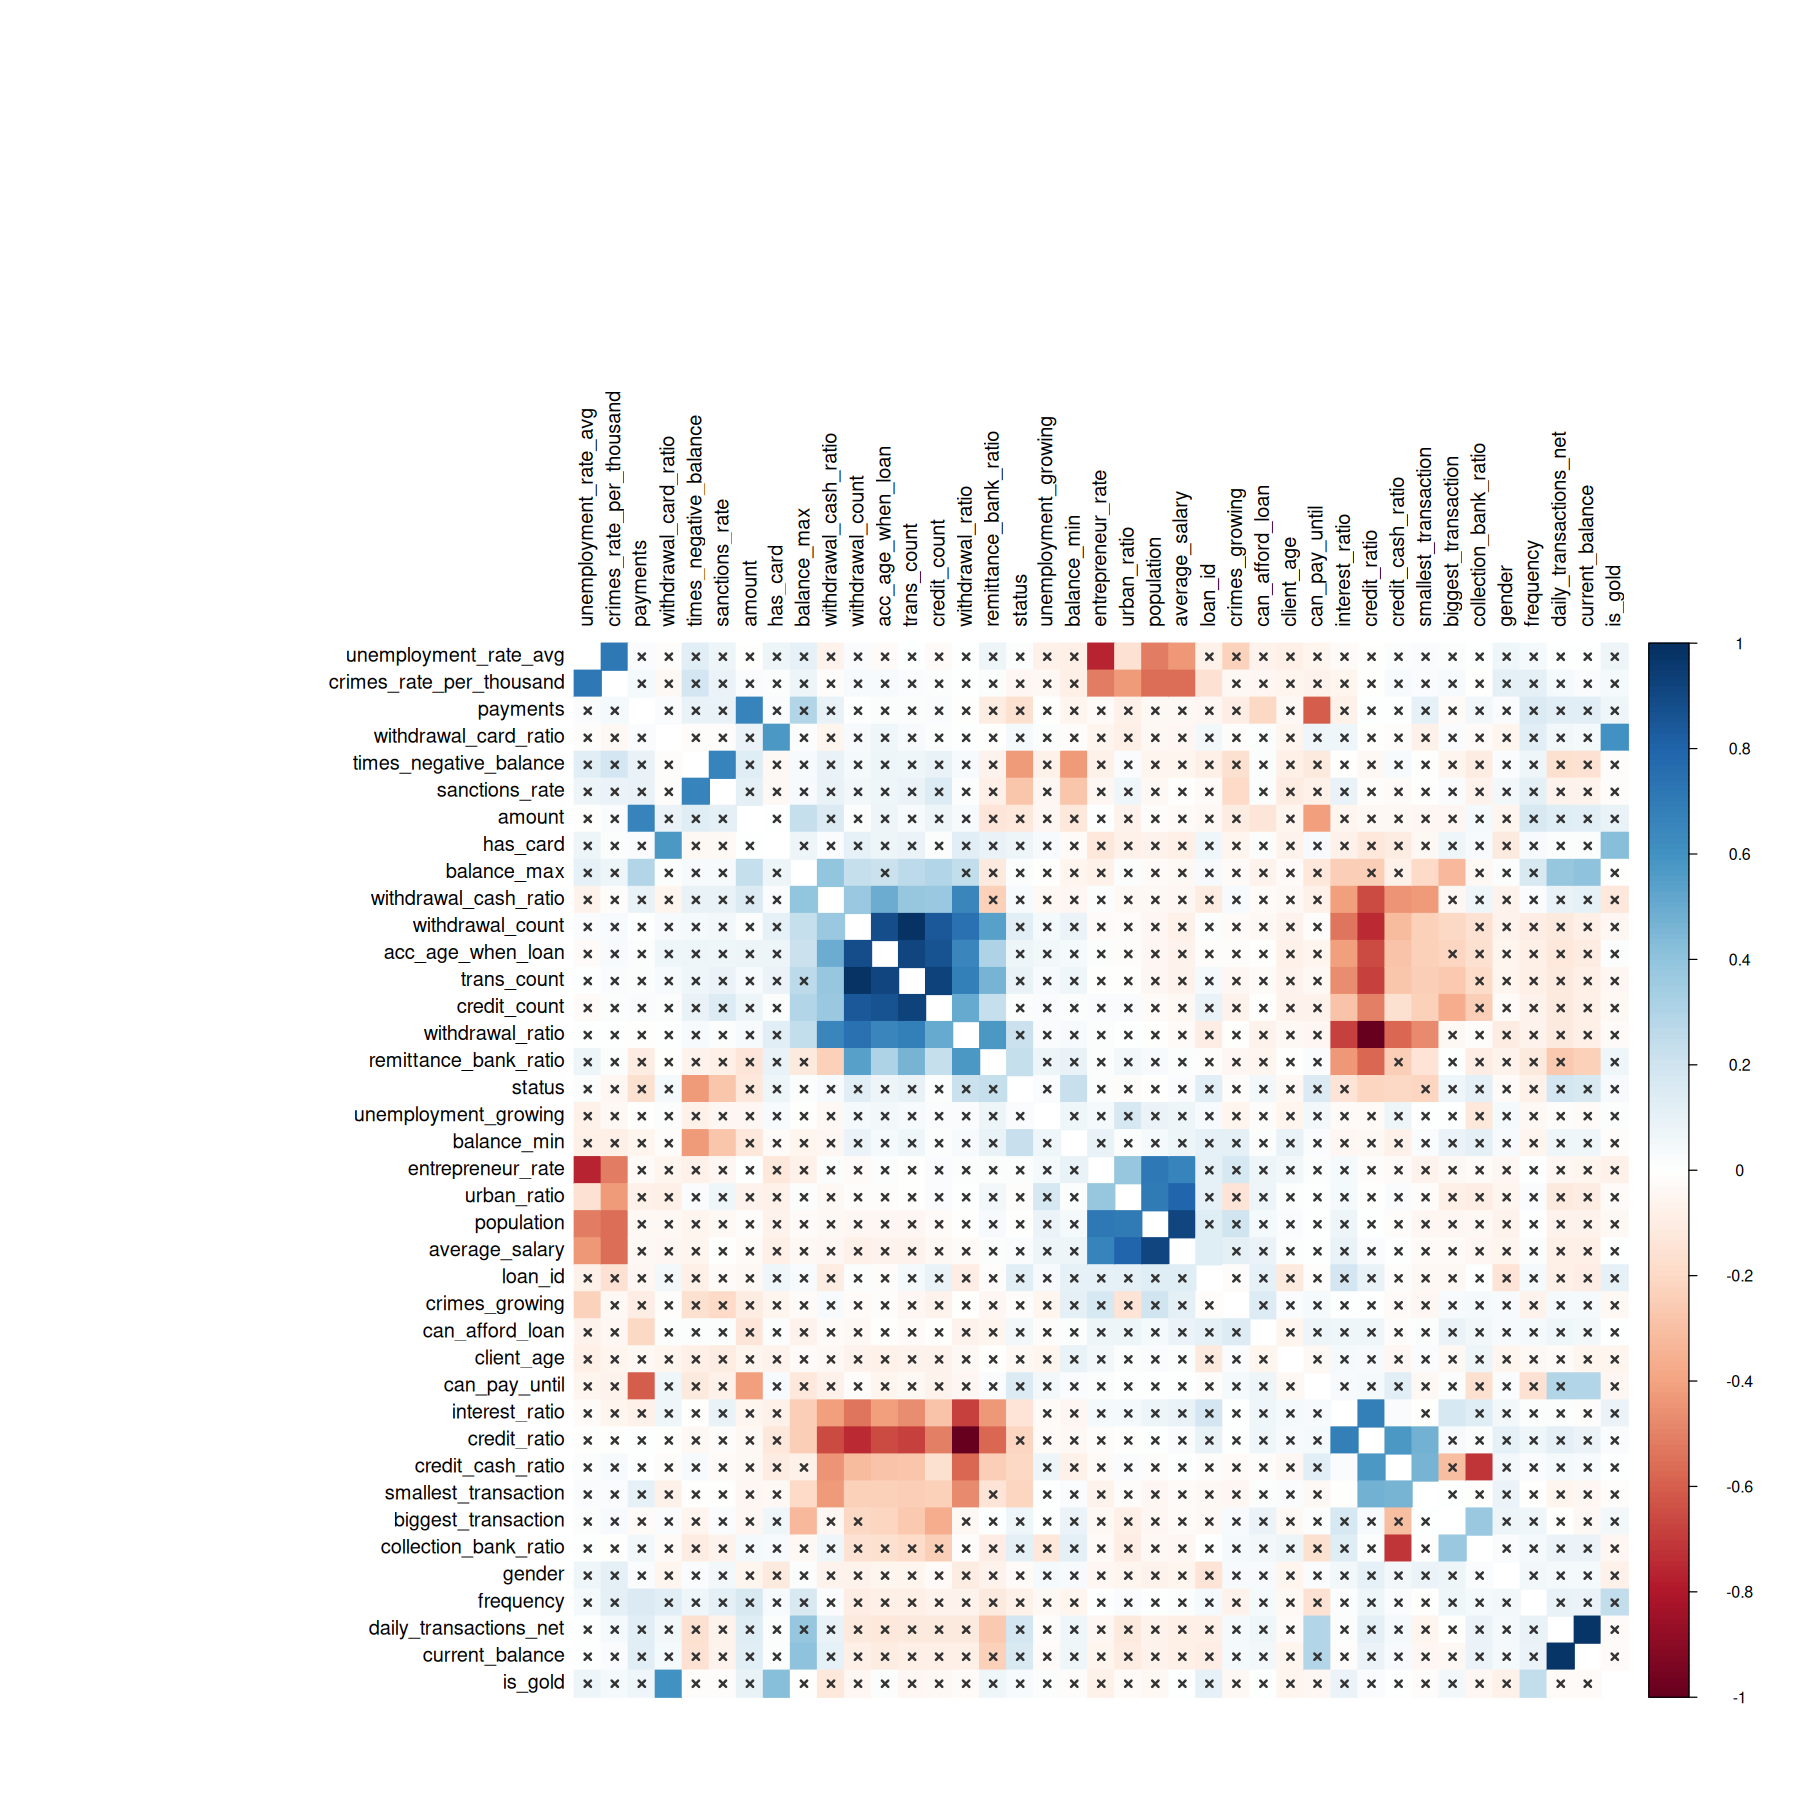

In [69]:
data_cor <- data %>%
    select_if(is.numeric) %>%
    cor(.)

testRes <- cor.mtest(data_cor, conf.level = 0.95)

options(repr.plot.width=15, repr.plot.height=15)
## add significant level stars
corrplot(data_cor, p.mat = testRes$p, method = 'color', diag = FALSE,
         sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.7,
         insig = 'pch', pch.col = 'grey20', order = 'AOE', tl.col="black")
options(repr.plot.width=7, repr.plot.height=7)

In this matrix, the insignificant correlations are marked with an "x", so we won't consider those for now.
Let's look at what attributes seem to be more directly correlated with our target variable, the status, and how:
- **sanctions_rate**: High sanctions rate seem to be correlated with **unsuccessful** loans;
- **times_negative_balance**: Having an account that has had negative balace more times seems to be correlated with **unsuccessful** loans;
- **remittance_bank_ratio**: Having an account that has had more "remittance to another bank" operations seems to be correlated with **successful** loans;
- **balance_min**: Higher lowest balance on the account seems to be correlated with **successful** loans; 
- **can_pay_until**: Having money to cover the payments for a longer duration seems to be associated with **successful** loans; 
- **interest_ratio**: Having an account that has had more "interest credited" operations seems to be correlated with **unsuccessful** loans;
- **credit_ratio**: Having an account that has had more "credit card withdrawal" operations seems to be correlated with **unsuccessful** loans;
- **credit_cash_ratio**: Having an account that has had more "credit in cash" operations seems to be correlated with **unsuccessful** loans;
- **smallest_transaction**: Having had a higher amount for the smallest_transactions (no small transactions made) seems to be correlated to **unsuccessful** loans.

We can test some of these by plotting graphs showing how these variables influence the loan success, and try to find other relations between the data.

### Loan status and sanctions rate

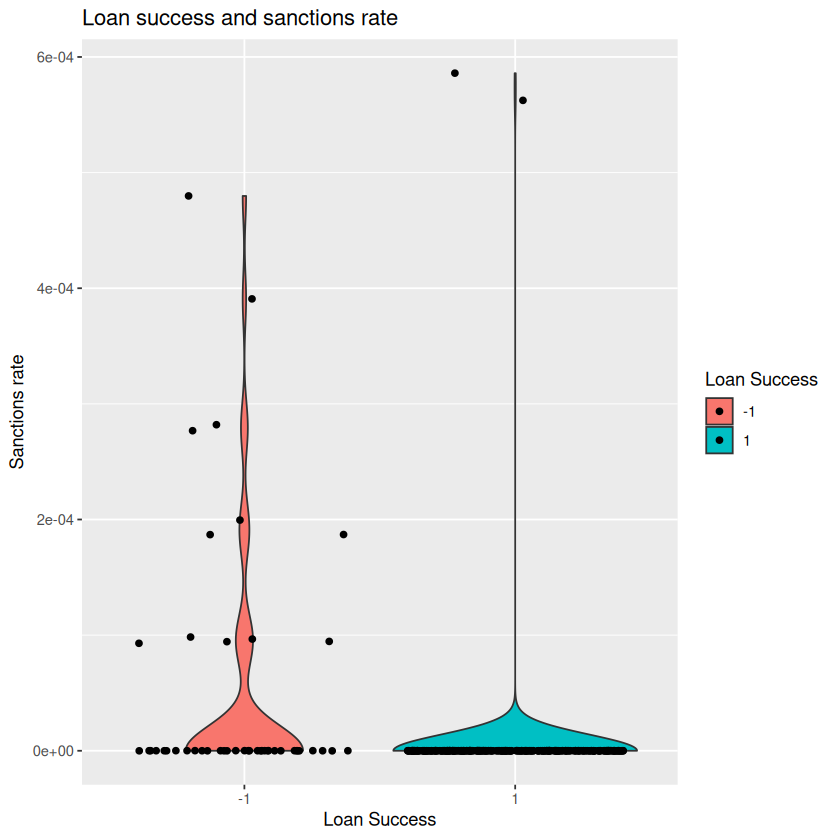

In [145]:
ggplot(data, aes(x=as.factor(status), y=sanctions_rate, fill=as.factor(status))) + 
  geom_violin() +
  labs(fill="Loan Success", x="Loan success", y="Sanctions rate", title="Loan success and sanctions rate") +
  geom_jitter() 

Looking at the plot, we can see that, most of the accounts that have been sanctioned have had unsuccessful loans. There are also two outliers for the successful loans plot, but they are not significant enough to have any consequence on the correlation.

### Loan status and the lowest balance the account has had

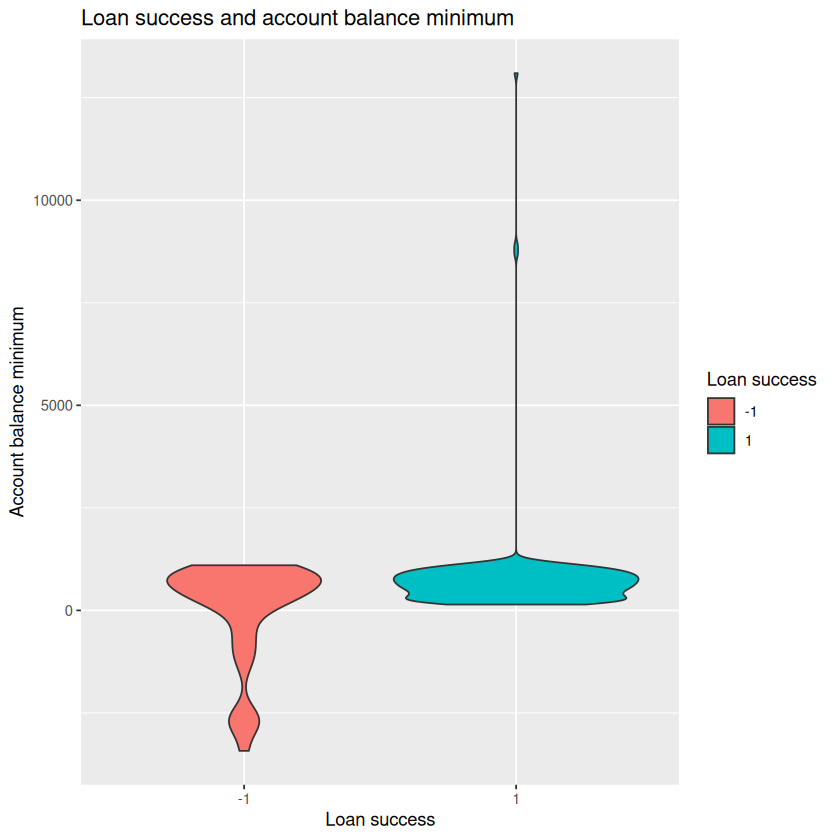

In [147]:
ggplot(data, aes(x=as.factor(status), y=balance_min, fill=as.factor(status))) + 
  geom_violin() +
  labs(fill="Loan success", x="Loan success", y="Account balance minimum", title="Loan success and account balance minimum")

As we can see, unsuccessful loans come seem to come from accounts that have had lower lowest balances previously. Negative balances seem to be more common in accounts that have had unsuccessful loans.

### Loan status and times the account's balance was negative

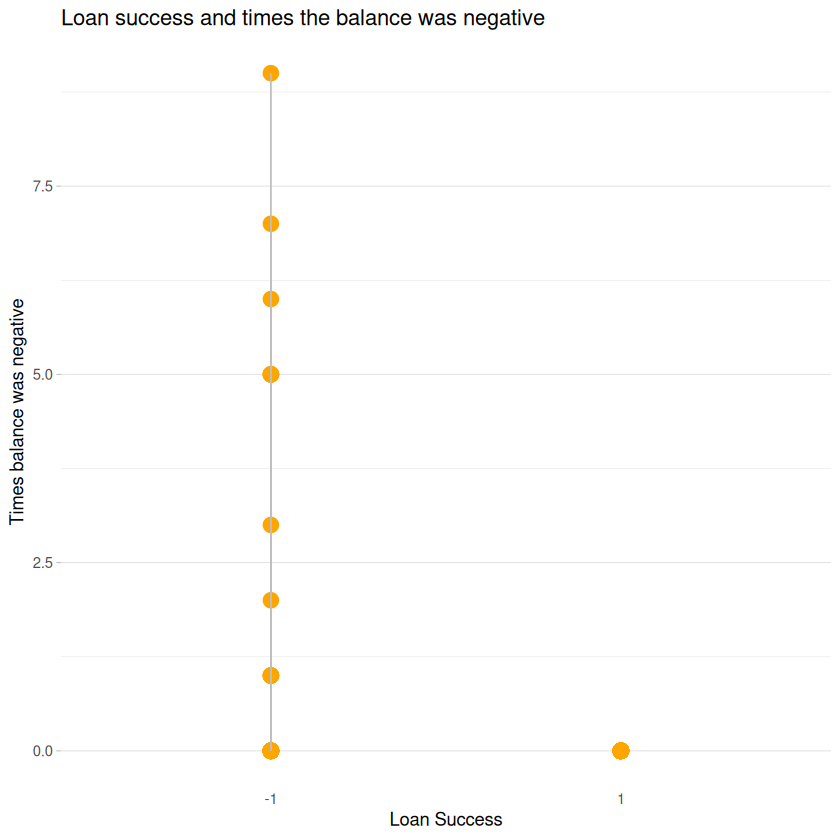

In [151]:
ggplot(data, aes(x=as.factor(status), y=times_negative_balance)) +
  geom_point( color="orange", size=4) +
  labs(x="Loan Success", y="Times balance was negative", title="Loan success and times the balance was negative") +
  theme_light() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.border = element_blank(),
    axis.ticks.x = element_blank()
  ) +
  geom_segment( aes(x=as.factor(status), xend=as.factor(status), y=0, yend=times_negative_balance), color="grey")

Confirming what we saw in the last analysis, we can gather that none of the successful loans from the dataset came from an account that has had negative balance.

### Loan status and whether or not the average person in the district could afford it

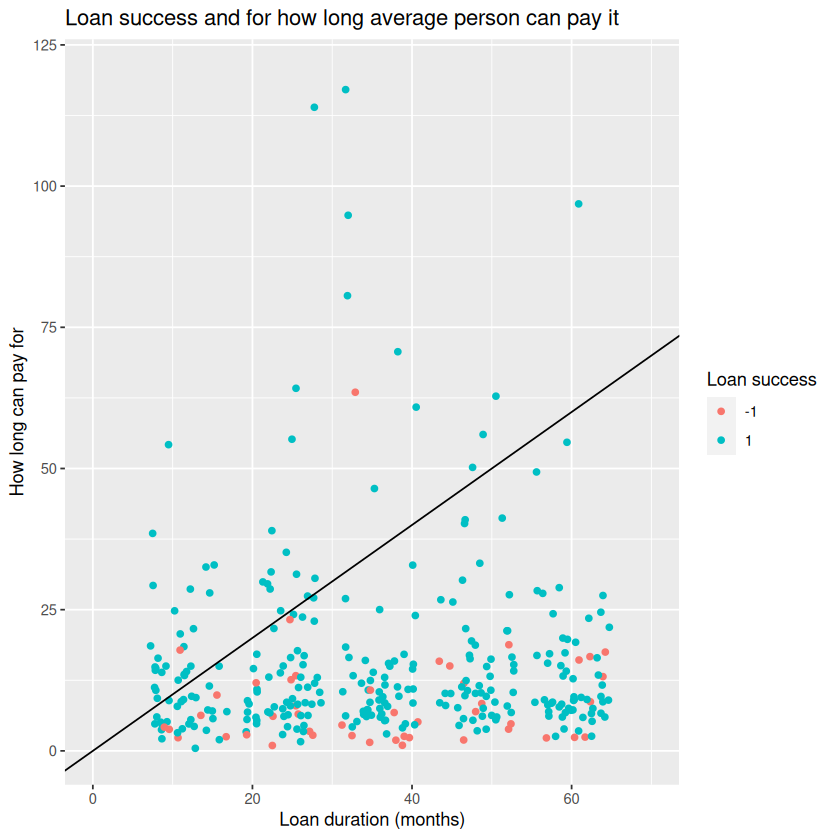

In [152]:
duration <- data$amount/data$payments

ggplot(data, aes(x=duration, y=can_pay_until, color=as.factor(status))) +
geom_jitter() +
labs(color="Loan success", x="Loan duration (months)", y="How long can pay for", title="Loan success and for how long average person can pay it") +
ylim(0,120) +
xlim(0,70) +
geom_abline(slope=1, intercept = 0)

The can_pay_until attribute is derived from average_salary / payments, which means that it is the estimated time an average person from the district where the loan was asked will take to pay the loan back. In the plot above, we have plotted those variables and an y = x line, to better see which are the loans where the can_pay_until was lower than the duration, that is, which are the loans that an average person in those conditions could not pay back in time (represented by the dots under the line). 

Extracting conclusions from this graph alone could be tricky, as there are way less points above the line than below. But we can see that out of the unsuccessful loans, most of them happen under the line. That is, most of the unsuccessful loans where made by accounts that could not afford paying them back in time given the only income they had was the average salary of the district.

### Loan status and operations the account has done

Since the success of a loan seemed to be correlated to variables such as "remittance_bank_ratio", "interest_ratio", "credit_ratio" and "credit_cash_ratio", we decided to plot a graph that would show a representation of which types of operations were more common on accounts with successful and unsuccessful loans. This one envolves some data preparation from scratch in order to access all the needed variables.

In [110]:
trans_data <- read.csv("../data/trans_dev.csv", sep=";")
loan_data <- read.csv("../data/loan_dev.csv", sep=";")
trans_data <- replace(trans_data, (trans_data == "" | trans_data == " "), NA)
colnames(trans_data)[colnames(trans_data) == "k_symbol"] <- "category"
trans_data <- transform(trans_data,
    operation = ifelse(
      is.na(trans_data$operation) | trans_data$operation == "" |
        trans_data$operation == " ",
      "interest credited",
      operation
    )
  )
trans_data$category[is.na(trans_data$category)] <- "other"
loan_data[loan_data$status == -1, ]$status <- 0
trans_loan <- loan_data %>%
    left_join(trans_data, by = "account_id") %>%
    select(operation,status) %>%
    group_by(status) %>%
    mutate(status_n = n())
trans_loan_new <- trans_loan %>%
    group_by(operation, status, status_n) %>%
    mutate(n = n()) %>%
    distinct()

We can now make the plot.

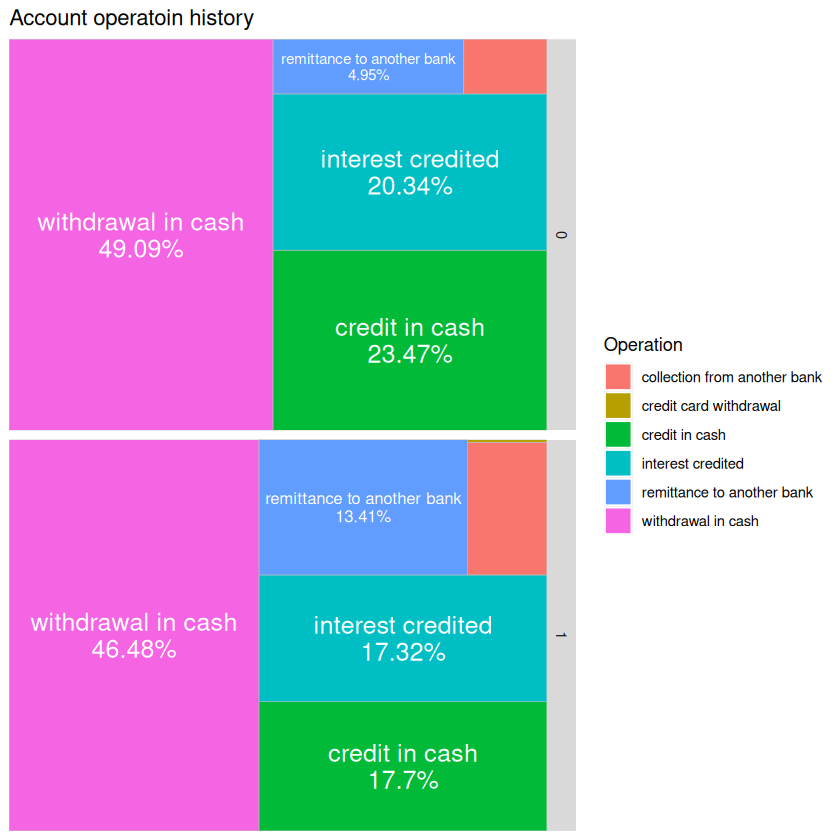

In [156]:
ggplot(trans_loan_new, aes(area=n, fill=as.factor(operation), label=paste(operation,paste(round(100 * n/status_n, digits=2),"%",sep=""),sep="\n"))) +
  geom_treemap() +
  labs(fill="Operation", title="Account operatoin history") +
  geom_treemap_text(
     colour = "white",
     place = "centre",
     size = 15) +
  facet_grid(status ~ .)

Analysing the graphs above, the main point to note is that successful loans tendentially come from accounts with more "remittance to another bank" operations.

### Loan status and smallest transaction made

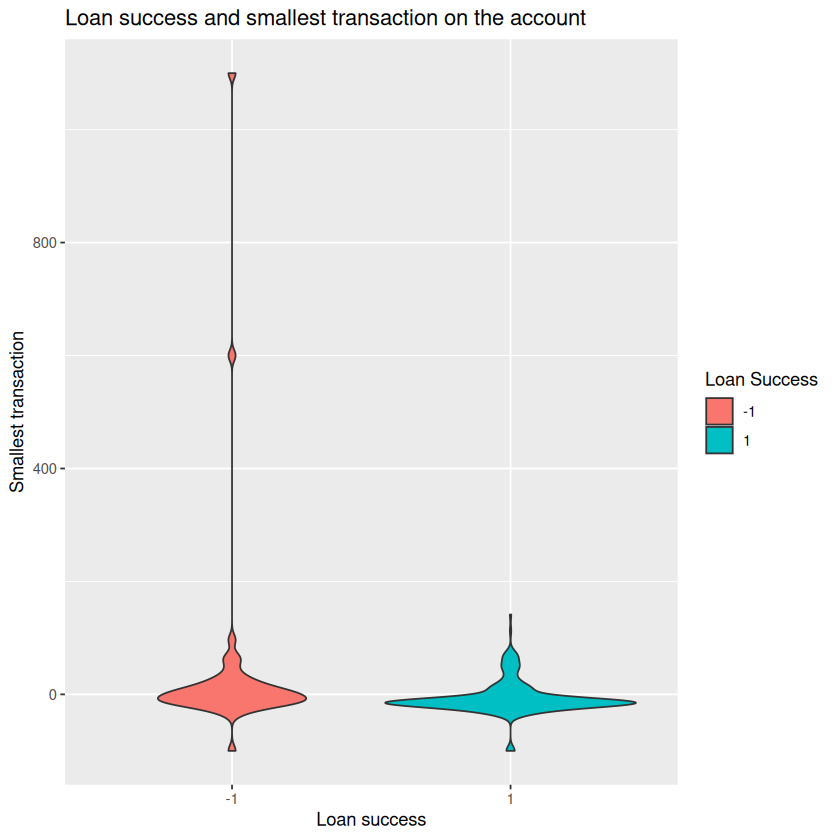

In [158]:
ggplot(data, aes(x=as.factor(status), y=smallest_transaction, fill=as.factor(status))) + 
  labs(fill="Loan Success", x="Loan success", y="Smallest transaction", title="Loan success and smallest transaction on the account") +
  geom_violin() 

This one doesn't seem to be as correlated as the others, being difficult to take any conclusion from the plot.
We can also see 2 outliers for the unsuccessfull loans section, where the account making the loan had very high values of smallest transaction, which could mean these accounts make big transactions only.